In [1]:
import pickle
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch

from models.times_net import TimesNet
from utils.time_features import time_features

In [2]:
df = pd.read_csv("data/train.csv")
df.index = pd.to_datetime(df['datetime'])
df = df.resample("d").last()
df = df.reset_index(drop=True)
df

,datetime,Open,High,Low,close,Volume,quote_av,trades,tb_base_av,tb_quote_av
0,2018-01-01 23:00:00,134.55,135.00,133.55,133.80,350.218495,4.701454e+04,4018,155.590981,2.089080e+04
1,2018-01-02 23:00:00,148.00,148.87,146.00,146.75,769.349881,1.134126e+05,5812,469.505566,6.921433e+04
2,2018-01-03 23:00:00,147.92,149.41,147.10,149.19,653.924200,9.705313e+04,6629,532.040262,7.896493e+04
3,2018-01-04 23:00:00,148.96,151.00,147.74,150.59,897.734362,1.342843e+05,6226,626.968812,9.378512e+04
4,2018-01-05 23:00:00,170.21,171.76,168.01,169.60,934.761738,1.588206e+05,8538,549.218303,9.331839e+04
...,...,...,...,...,...,...,...,...,...,...
2274,2024-03-24 23:00:00,669.51,676.28,669.25,672.09,3533.010400,2.373447e+06,135327,2327.466330,1.563584e+06
2275,2024-03-25 23:00:00,703.09,704.69,697.25,698.79,1145.812140,8.031998e+05,76302,483.386610,3.388681e+05
2276,2024-03-26 23:00:00,702.49,703.05,699.45,699.87,712.765170,4.998365e+05,59263,340.776950,2.389929e+05
2277,2024-03-27 23:00:00,694.39,696.37,690.72,694.69,1357.089450,9.419139e+05,60525,739.894470,5.135537e+05


In [3]:
@dataclass
class Args:
    task_name = "forecasting"
    seq_len = 336
    label_len = 168
    pred_len = 63
    c_in = 1


args = Args()

In [4]:
from models.d_linear import DLinear


path = "checkpoints/tas_forecasting__mod_DLinear__id_test_run__sca_S__fea_S__seq_336__lab_168__pre_63__c_i_1__epo_80__pat_10__des_dlinear_test_run/"


net = DLinear(args)
net.load_state_dict(torch.load(path + "checkpoint.pth", map_location=torch.device("cuda")))
net = net.to("cuda")

with open(path + 'scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [9]:
def make_data_stamp(data, pred_len, freq="h"):
    future_hours = pd.date_range(data["datetime"].max(), periods=pred_len + 1, freq=freq)[1:]
    df_future = pd.DataFrame({"datetime": future_hours})
    data = pd.concat([data, df_future]).reset_index(drop=True)
    data_stamp = time_features(pd.to_datetime(data["datetime"].values), freq=freq)
    data_stamp = data_stamp.transpose(1, 0)
    return data_stamp


def make_input_data(data, data_stamp, scaler):
    x = data["close"].values.reshape(-1, 1)
    x = scaler.transform(x)
    x = torch.Tensor(x).to("cuda")
    x = x.unsqueeze(0)

    x_mark = data_stamp[: args.seq_len]
    x_mark = torch.Tensor(x_mark).to("cuda")

    y = torch.zeros_like(x[:, -args.pred_len :, :]).float()
    y = torch.cat([x[:, -args.label_len :, :], y], dim=1).float().to("cuda")

    y_mark_begin = args.label_len + args.pred_len
    y_mark = data_stamp[-y_mark_begin:]
    y_mark = torch.Tensor(y_mark).to("cuda")
    return x, x_mark, y, y_mark

def forecast(df, date):
    num = df.last_valid_index() - (df.last_valid_index() - df[df["datetime"] == date].index)[0]
    data = df.iloc[num:]
    print(len(data))
    data_stamp = make_data_stamp(data, args.pred_len)

    x, x_mark, y, y_mark = make_input_data(data, data_stamp, scaler)
    
    out = net(x, x_mark, y, y_mark)
    out = np.array(out.detach().cpu()).squeeze(0)
    out = scaler.inverse_transform(out)
    out = out.squeeze()
    return out

In [10]:
date = "2023-12-24 23:00:00"

out = forecast(df, date)

96


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x96 and 336x63)

In [245]:
new_date = np.linspace(1, len(out), len(out) * 24)
new_data = np.interp(new_date, np.arange(1, len(out) + 1), out)

In [250]:
submission = pd.read_csv("data/sample_submission.csv")
submission["Close"] = new_data
submission

,Time,Close
0,2024-03-29 00:00:00,671.902039
1,2024-03-29 01:00:00,672.109189
2,2024-03-29 02:00:00,672.316340
3,2024-03-29 03:00:00,672.523491
4,2024-03-29 04:00:00,672.730641
...,...,...
1507,2024-05-30 19:00:00,687.983287
1508,2024-05-30 20:00:00,688.280098
1509,2024-05-30 21:00:00,688.576909
1510,2024-05-30 22:00:00,688.873721


In [254]:
submission.to_csv("submissions/timesnet_e_1_ff_64_topk_2.csv", index=False)

In [255]:
pd.read_csv("submissions/timesnet_e_1_ff_64_topk_2.csv")

,Time,Close
0,2024-03-29 00:00:00,671.902039
1,2024-03-29 01:00:00,672.109189
2,2024-03-29 02:00:00,672.316340
3,2024-03-29 03:00:00,672.523491
4,2024-03-29 04:00:00,672.730641
...,...,...
1507,2024-05-30 19:00:00,687.983287
1508,2024-05-30 20:00:00,688.280098
1509,2024-05-30 21:00:00,688.576909
1510,2024-05-30 22:00:00,688.873721


<Axes: >

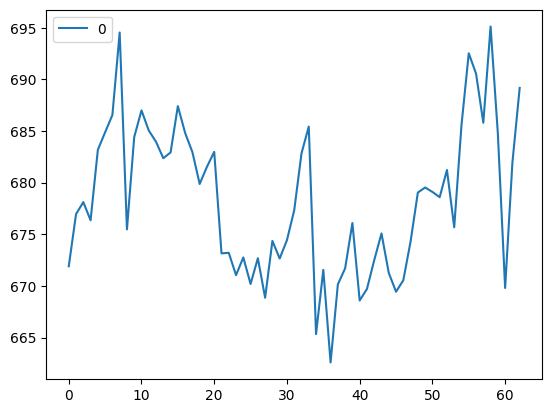

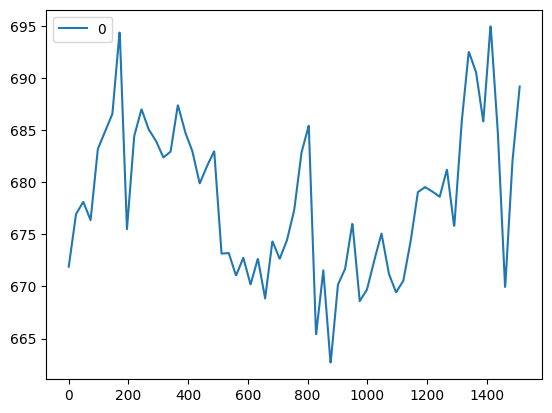

In [239]:
pd.DataFrame(out).plot()

pd.DataFrame(new_data).plot()

<Axes: >

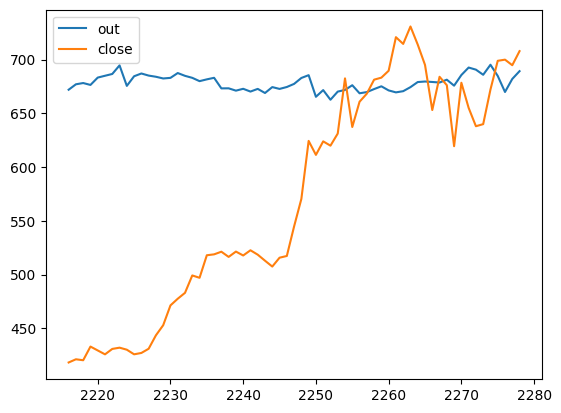

In [208]:
num = df.last_valid_index() - args.pred_len + 1

pd.DataFrame({
    "out": out,
    "close": df.iloc[num:]["close"]
}).plot()
